## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [5]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 2. Create Gaussian blurs with varying widths and occluding bars

In [6]:
# Number of Gaussian blurs images
nGauss = 1500

# Pixel size : heightxwidth = 91x91
imgSize   = 91

x = np.linspace(start=-4, stop=4, num=imgSize)

# Return coordinate matrices from coordinate vectors.
X,Y = np.meshgrid(x,x)

# vary the width smoothly
widths = np.linspace(2,20,nGauss)

# 1 : number of channel(grey scale)
# initialize two tensor containing images
imagesOcc   = torch.zeros(nGauss,1,imgSize,imgSize)
imagesNoOcc = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

    # create the gaussian with random centers
    ro = 1.5*np.random.randn(2) # ro = random offset
    G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

    # add noise
    G  = G + np.random.randn(imgSize,imgSize)/5
    
    # add the original to the noocc
    imagesNoOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
      
    # add a random bar randomly
    i1 = np.random.choice(np.arange(2,28))
    i2 = np.random.choice(np.arange(2,6))
    
    if np.random.randn()>0:
        G[i1:i1+i2,] = 1
    else:
        G[:,i1:i1+i2] = 1
  
    # add to the tensor with occlusion
    imagesOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

#### Visualizing some images

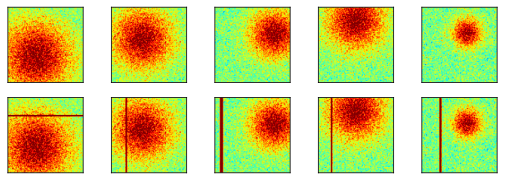

In [7]:
# visualize some images
fig,ax = plt.subplots(2,5,figsize=(9,3), dpi=135)

for i in range(5):
    
    whichpic = np.random.randint(nGauss)
    
    ax[0,i].imshow(np.squeeze( imagesNoOcc[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])

    ax[1,i].imshow(np.squeeze( imagesOcc[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])


plt.show()

## 3. Create the DL model

In [9]:
# create a class for the model
def makeTheNet(LR):

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()
      
            # encoding layer
            self.enc = nn.Sequential(
                      nn.Conv2d(1,6,3,padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2),
                
                      nn.Conv2d(6,4,3,padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)  
                      )
      
            # decoding layer
            # Not adding activation function in second layer because this is going to the final 
            # output of the Model.
            self.dec = nn.Sequential(
                      nn.ConvTranspose2d(4,6,3,2),
                      nn.ReLU(),
                      nn.ConvTranspose2d(6,1,3,2), 
              )

        def forward(self,x):
            return self.dec( self.enc(x) )
  
    # create the model instance
    net = gausnet()

    # loss function
    lossfunc = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=LR)

    return net,lossfunc,optimizer

#### Testing the Model

 
torch.Size([10, 1, 91, 91])


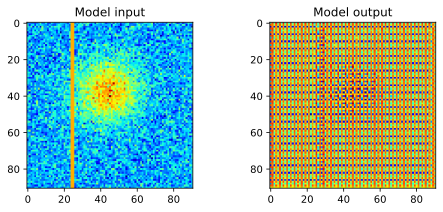

In [12]:
# test the model with one batch
net_test, lossfunc_test, optimizer_test = makeTheNet(LR=0.01)

yHat_test = net_test(imagesOcc[:10,:,:,:])

# check size of output
print(' ')
print(yHat_test.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3), dpi=135)

ax[0].imshow(torch.squeeze(imagesOcc[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')

ax[1].imshow(torch.squeeze(yHat_test[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

## 4. Create a function that trains the model

In [13]:
# function that trains the model

def function2trainTheModel(Model, lossfunc, optimizer, epochs, imagesOcc,imagesNoOcc, nGauss ):
  
    # initialize losses
    losses = torch.zeros(epochs)

    # loop over epochs
    for epochi in range(epochs):

        # Pick a set of images at random
        pics2use = np.random.choice(nGauss, size=32,replace=False)
         
        # get the input (has occlusions) and the target (no occlusions)
        X = imagesOcc[pics2use,:,:,:]
        Y = imagesNoOcc[pics2use,:,:,:]

        # forward pass and loss
        yHat = Model(X)
        loss = lossfunc(yHat,Y)
        losses[epochi] = loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # end epochs

    # function output
    return losses,Model

## 5.  Run the model

In [14]:
CNN_AE_Gaussian_model, lossfunc, Optimizer = makeTheNet(LR=0.01)

In [15]:
Losses,trained_Model= function2trainTheModel(Model=CNN_AE_Gaussian_model, 
                                             lossfunc=lossfunc, 
                                             optimizer=Optimizer, 
                                             epochs=200, 
                                             imagesOcc=imagesOcc,
                                             imagesNoOcc=imagesNoOcc,
                                             nGauss=nGauss )

## 6. Results Visualization

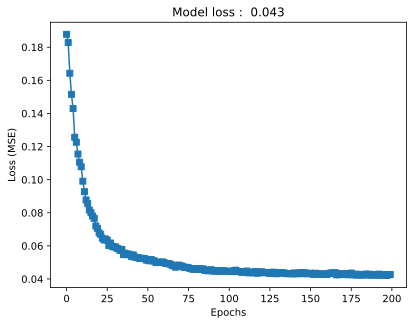

In [16]:
plt.plot(Losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Model loss :  {round(Losses[-1].item(),3)}')

plt.show()

## 7. visualize some images

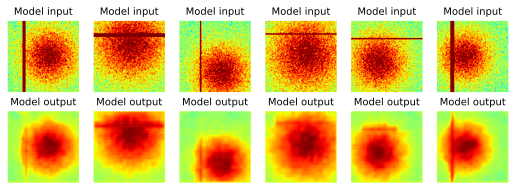

In [17]:
pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imagesOcc[pics2use,:,:,:]
yHat = trained_Model(X)

fig,axs = plt.subplots(2,6,figsize=(9,3), dpi=135)

for i in range(6):
  
    G = torch.squeeze( X[i,0,:,:] ).detach()
    O = torch.squeeze( yHat[i,0,:,:] ).detach()

    axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
    axs[0,i].axis('off')
    axs[0,i].set_title('Model input',fontsize=10)

    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
    axs[1,i].axis('off')
    axs[1,i].set_title('Model output',fontsize=10)

plt.show()